In [2]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

In [59]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"
import tempfile

from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

import tdgl
from tdgl.geometry import box, circle

tmpdir = tempfile.TemporaryDirectory(dir=os.getcwd())

plt.ioff()

# Definición del dispositivo a usar

In [4]:
length_units = "um"

coherence_length = 0.5
london_lambda = 2
d = 0.1
gamma = 1

layer = tdgl.Layer(london_lambda=london_lambda, coherence_length=coherence_length, thickness=d, gamma=gamma)

total_width = 12
total_length = 10
link_width = total_width / 3

x = total_width / 2
y = total_length / 2
points = [(-x, y), (-x + 3.5, y), (-x + 3.5, y - 1), (-x + 1, y - 3.5), (-x, y - 3.5), (-x, y)]
top_left_notch = (tdgl.Polygon(points=points))
bottom_left_notch = top_left_notch.scale(yfact=-1)

points = [(0,y), (x,y), (x, y - 3.5), (-1.0, y - 3.5), (-1.5, y - 3.0), (0, y - 1), (0,y)]
top_right_notch = (tdgl.Polygon(points=points))
bottom_right_notch = top_right_notch.scale(yfact=-1)

film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .difference(top_left_notch, bottom_left_notch, top_right_notch, bottom_right_notch)
    .resample(401)
    .buffer(0)
)

radius = 1.8
hole = (
    tdgl.Polygon("hole", points=circle(radius=radius, center=(-2.5, 0)))
)

source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.1*total_length))
    .translate(dx = -total_width / 2)
)

drain = source.scale(xfact=-1).set_name("drain")
#
probe_points = [(-5,0),(5,0)]


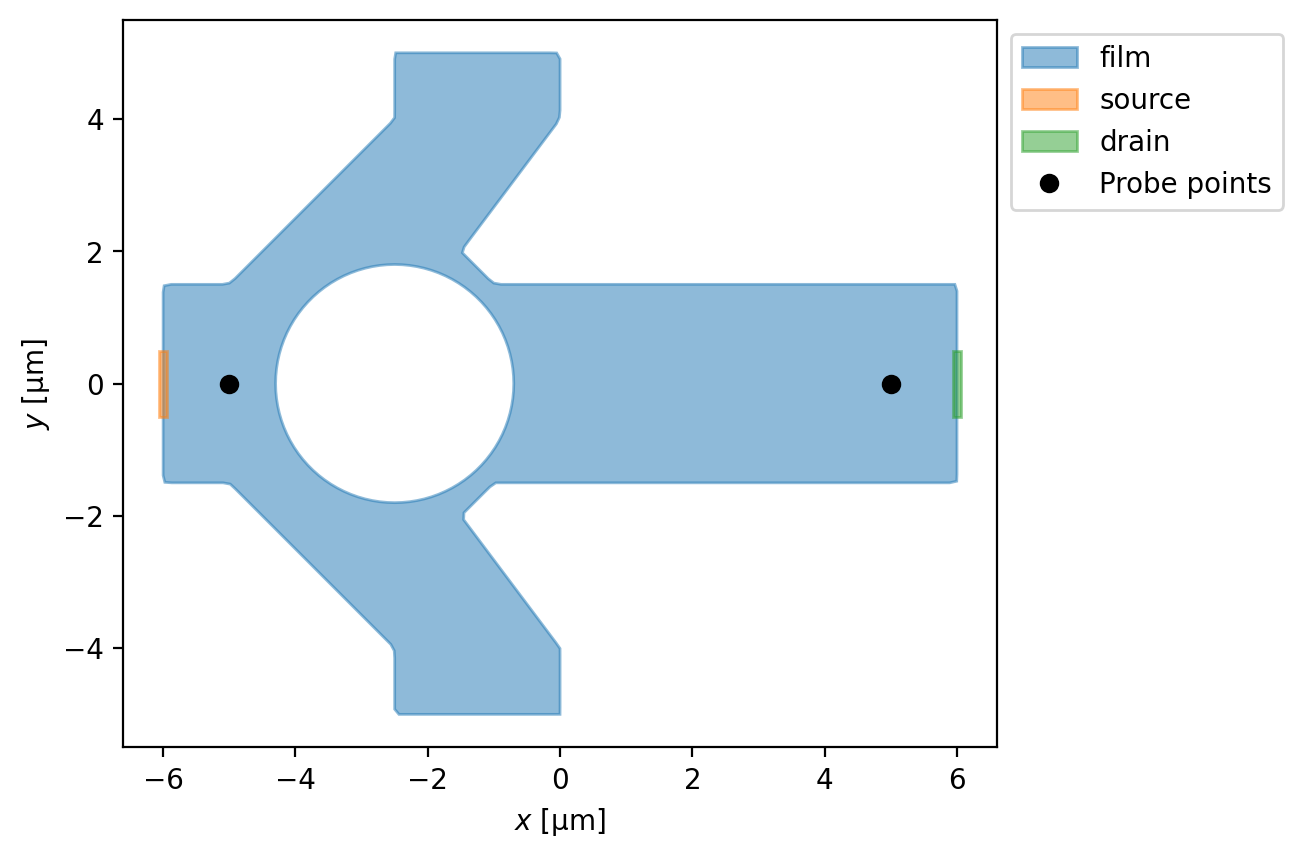

In [5]:
device = tdgl.Device(
    "original_device",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[source, drain],
    probe_points=probe_points,
)

fix, ax = device.draw()

Constructing Voronoi polygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2764/2764 [00:00<00:00, 33329.76it/s]


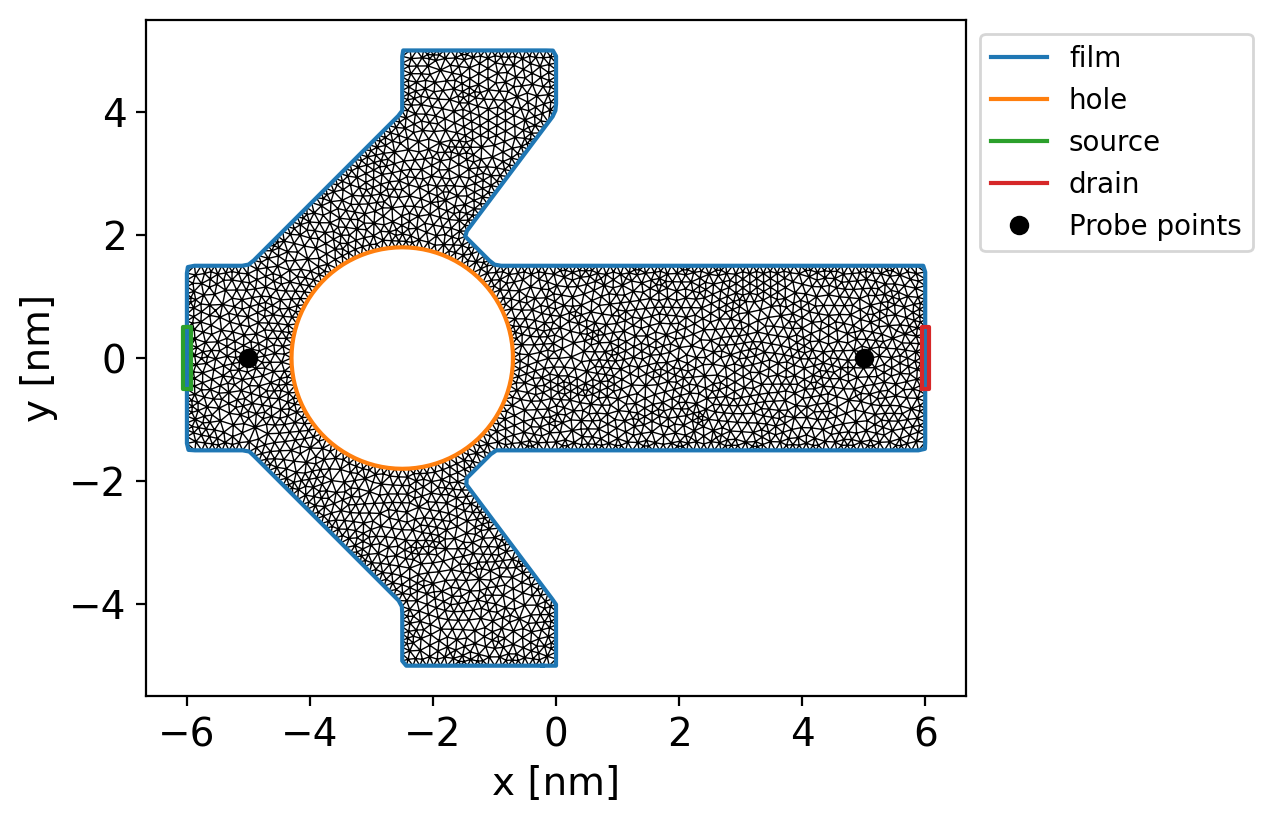

In [6]:
device.make_mesh(max_edge_length= coherence_length/2, smooth=100)

fig, ax = device.plot(mesh=True, legend=True, figsize=(9,4))

ax.set_xlabel("x [nm]",fontsize="14")
ax.set_ylabel("y [nm]",fontsize="14")
ax.tick_params(axis="both", labelsize=14)

In [6]:
options = tdgl.SolverOptions(
    solve_time = 200,
    output_file = os.path.join(tmpdir.name, "current_field.h5"),
    field_units= "mT",
    current_units= "uA",
)

# Gráfica de corrientes en el conductor

In [8]:
default_terminal_currents = {
    'source': 12,
    'drain' : -12
}

solution_without_field = tdgl.solve(device=device, options=options, terminal_currents=default_terminal_currents)

Simulating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 200/200 [00:13<00:00, 15.00tau/s ]


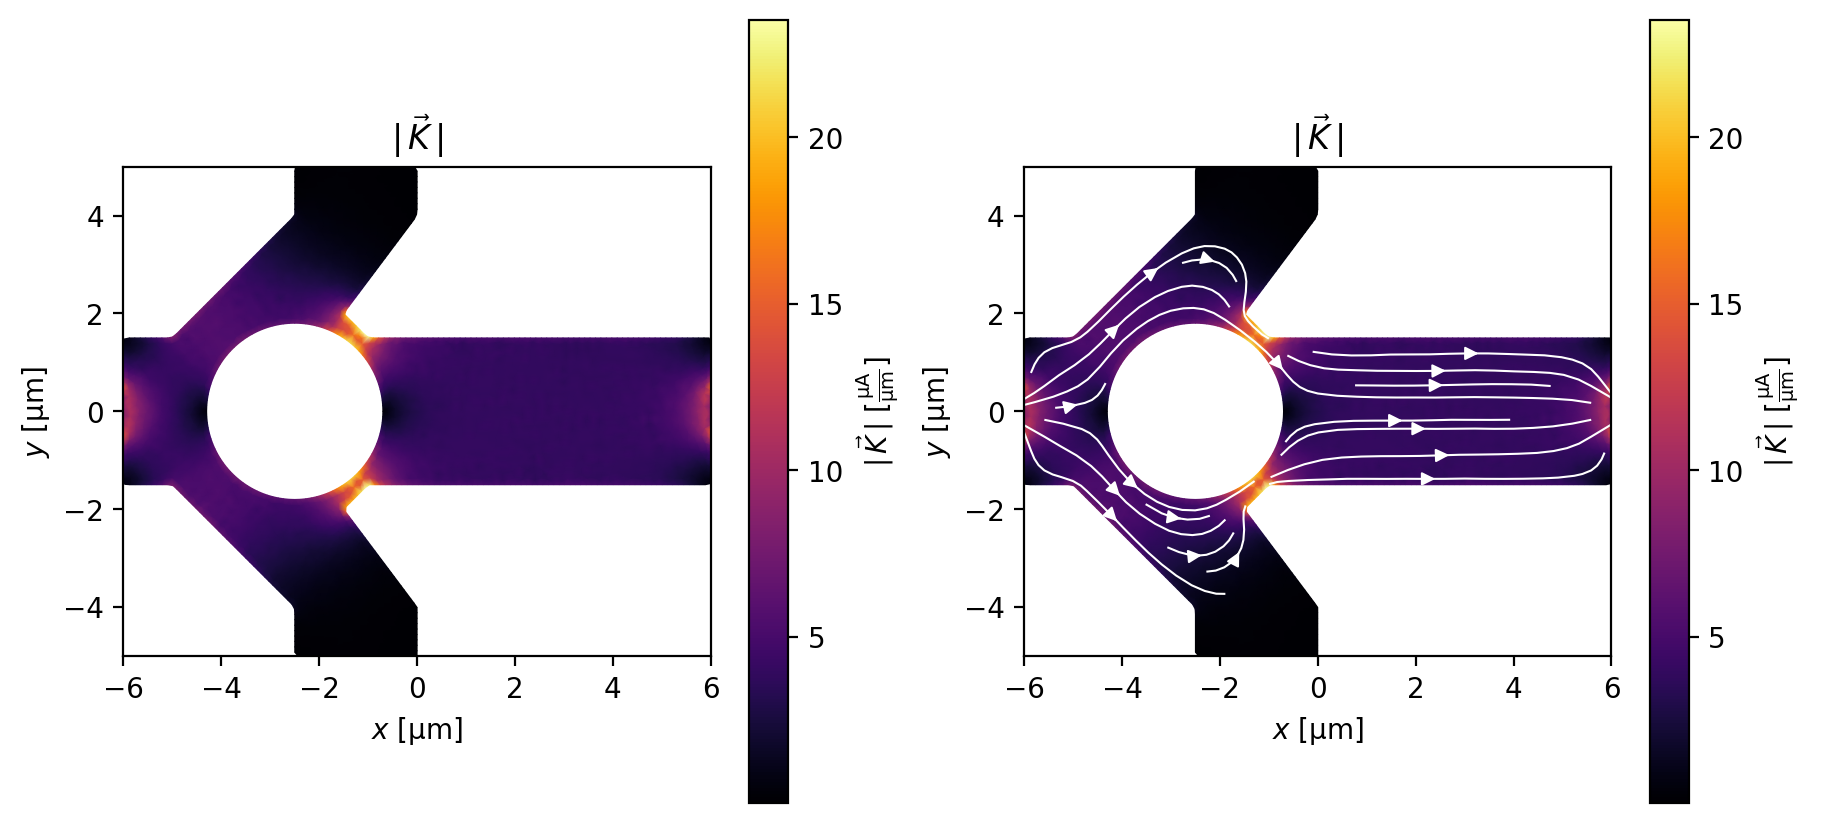

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

_ = solution_without_field.plot_currents(ax=axes[0], streamplot=False)
_ = solution_without_field.plot_currents(ax=axes[1])


# Graphic V vs I

In [ ]:
def get_mean_voltage(device, options, current):
    terminal_currents = {
        'source': current,
        'drain': -current,
    }

    solution = tdgl.solve(device=device, options=options, terminal_currents=terminal_currents)
    return solution.dynamics.mean_voltage()

currents = np.arange(0.0, 10, 0.02)

voltage_current_save_file = "V_vs_I_conductor_"
raw_data_path = os.path.join("raw_data", voltage_current_save_file + device.name + ".csv")

if os.path.exists(raw_data_path):
    os.remove(raw_data_path)

for current in currents:
    df = pd.DataFrame({'current_uA': [current], 'voltage_V': [get_mean_voltage(device, options, current)]})
    df.to_csv(raw_data_path, mode='a', header=not os.path.exists(raw_data_path), index=False)

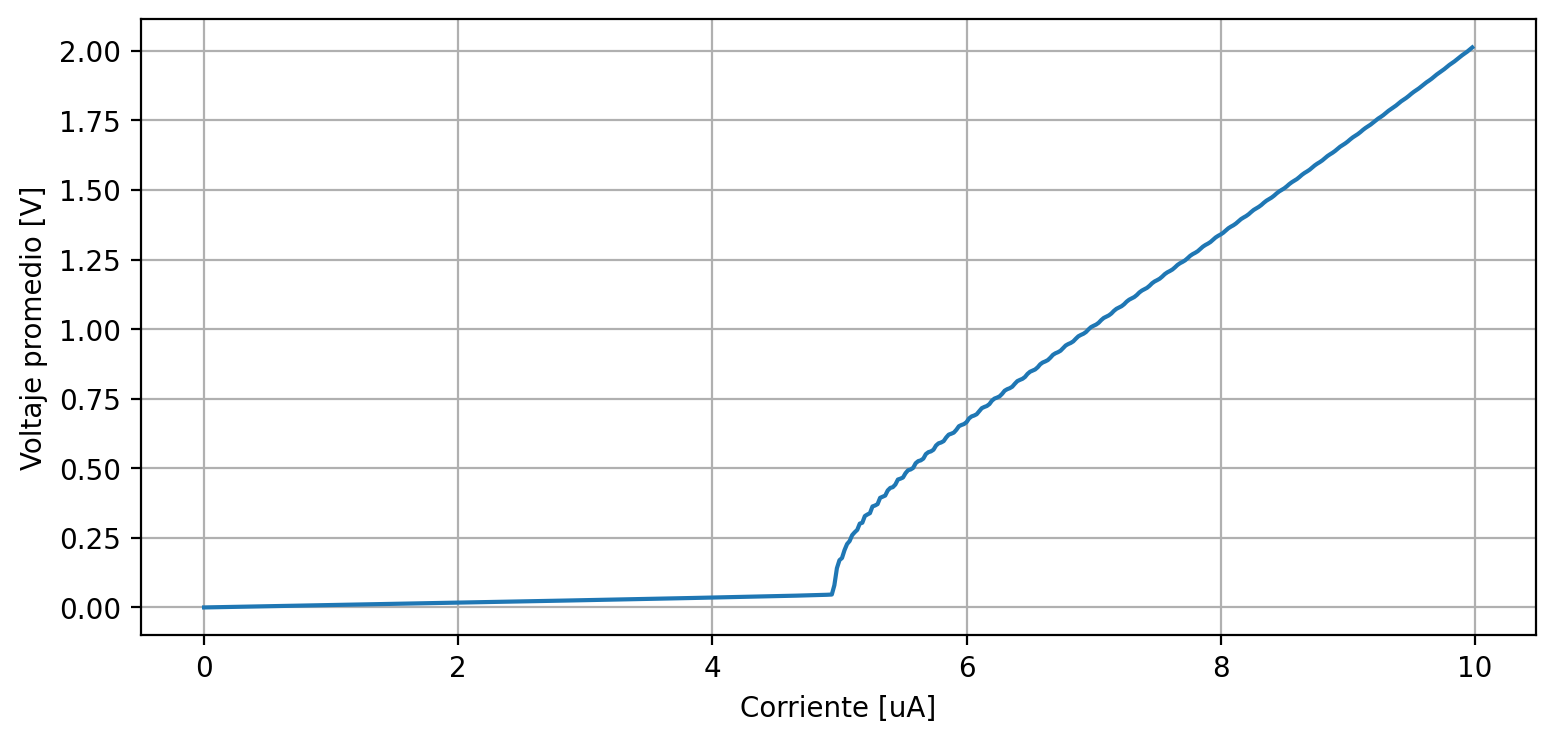

In [10]:
df = pd.read_csv(raw_data_path)
data = df.to_numpy()

voltages = [d[1] for d in data]
currents = [d[0] for d in data]

plt.figure(figsize=(9,4))
plt.plot(currents, voltages, linestyle='-')
plt.xlabel('Corriente [uA]')
plt.ylabel('Voltaje promedio [V]')
plt.grid(True)
plt.show()

# Current in multiple Source - Drain configurations

In [39]:
devices = []

left_source = source = (
    tdgl.Polygon("source", points=box(total_width / 100, 0.1*total_length))
    .translate(dx = -total_width / 2)
)

right_drain = left_source.scale(xfact=-1).set_name('drain')

top_source = (
    tdgl.Polygon("source", points=box(0.1*total_width, total_length/100))
    .translate(dy = total_length / 2, dx = -1.2)
)

bot_drain = top_source.scale(yfact=-1).set_name('drain')

top_probe = (-1.3, 4)
bot_probe = (-1.3, -4)
left_probe = (-5, 0)
right_probe = (5, 0)

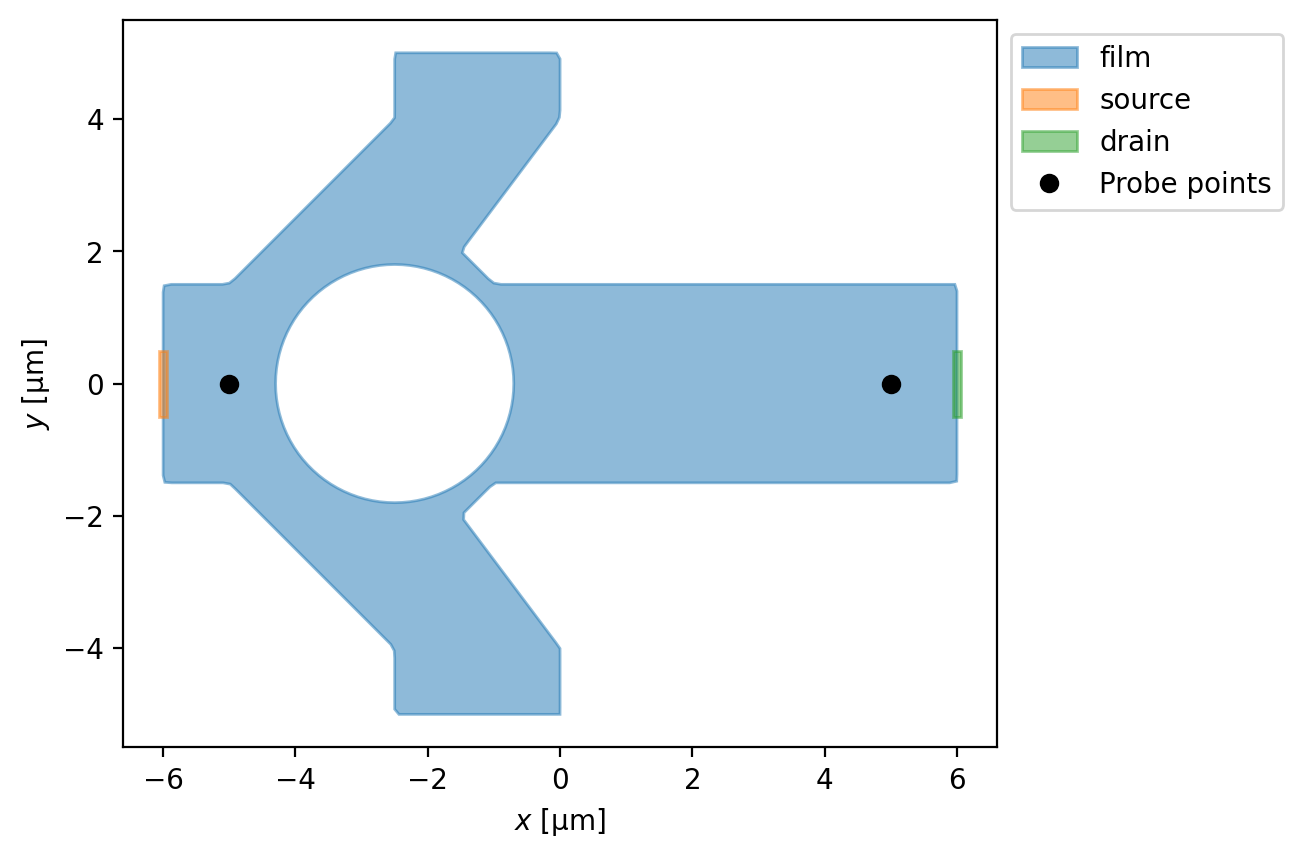

In [40]:
ltr_device = tdgl.Device(
    "ltr",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[left_source, right_drain],
    probe_points=[left_probe, right_probe],
)

devices.append(ltr_device)

fix, ax = ltr_device.draw()

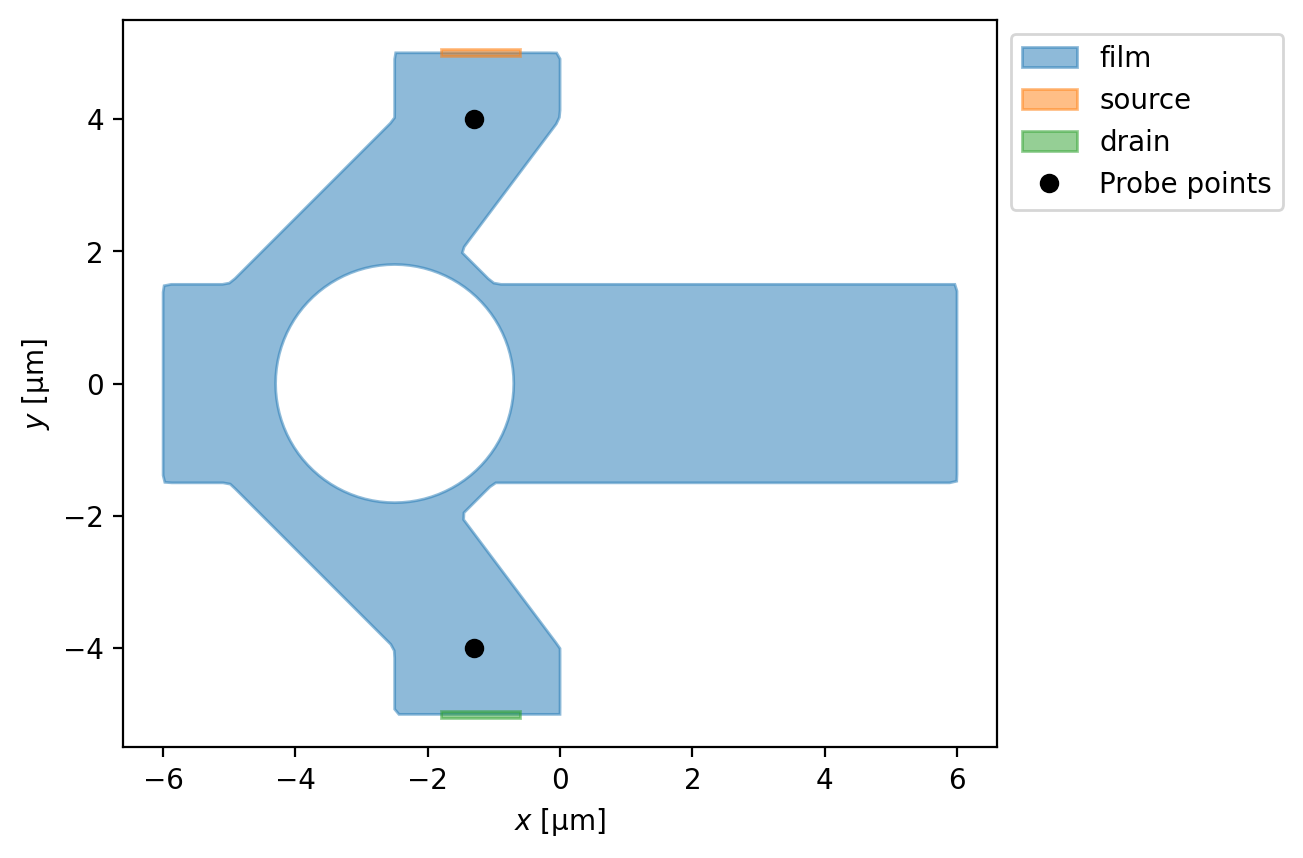

In [41]:
ttb_device = tdgl.Device(
    "ttb",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[top_source, bot_drain],
    probe_points=[top_probe, bot_probe],
)

devices.append(ttb_device)
fix, ax = device.draw()

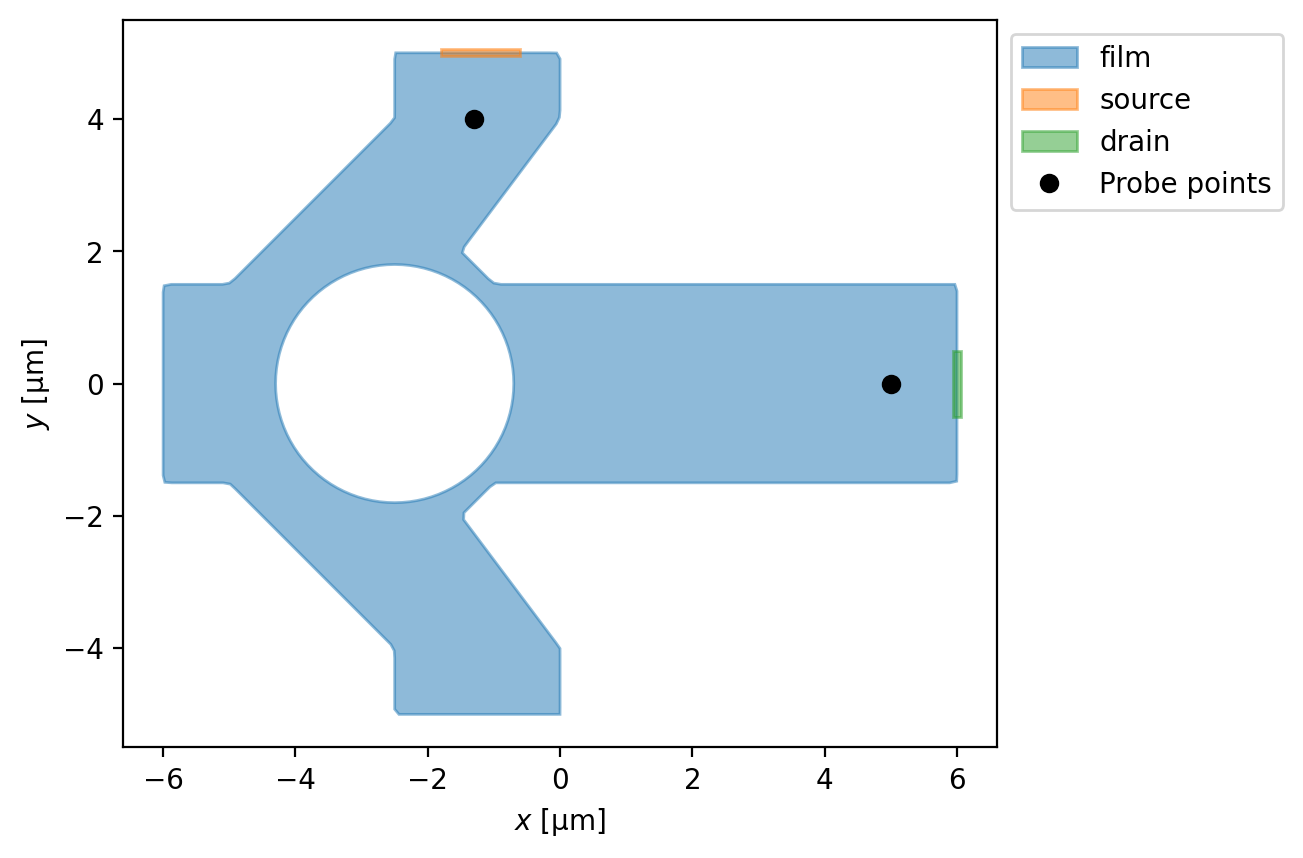

In [42]:
ttr_device = tdgl.Device(
    "ttr",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[top_source, right_drain],
    probe_points=[top_probe, right_probe],
)

devices.append(ttr_device)

fix, ax = ttr_device.draw()

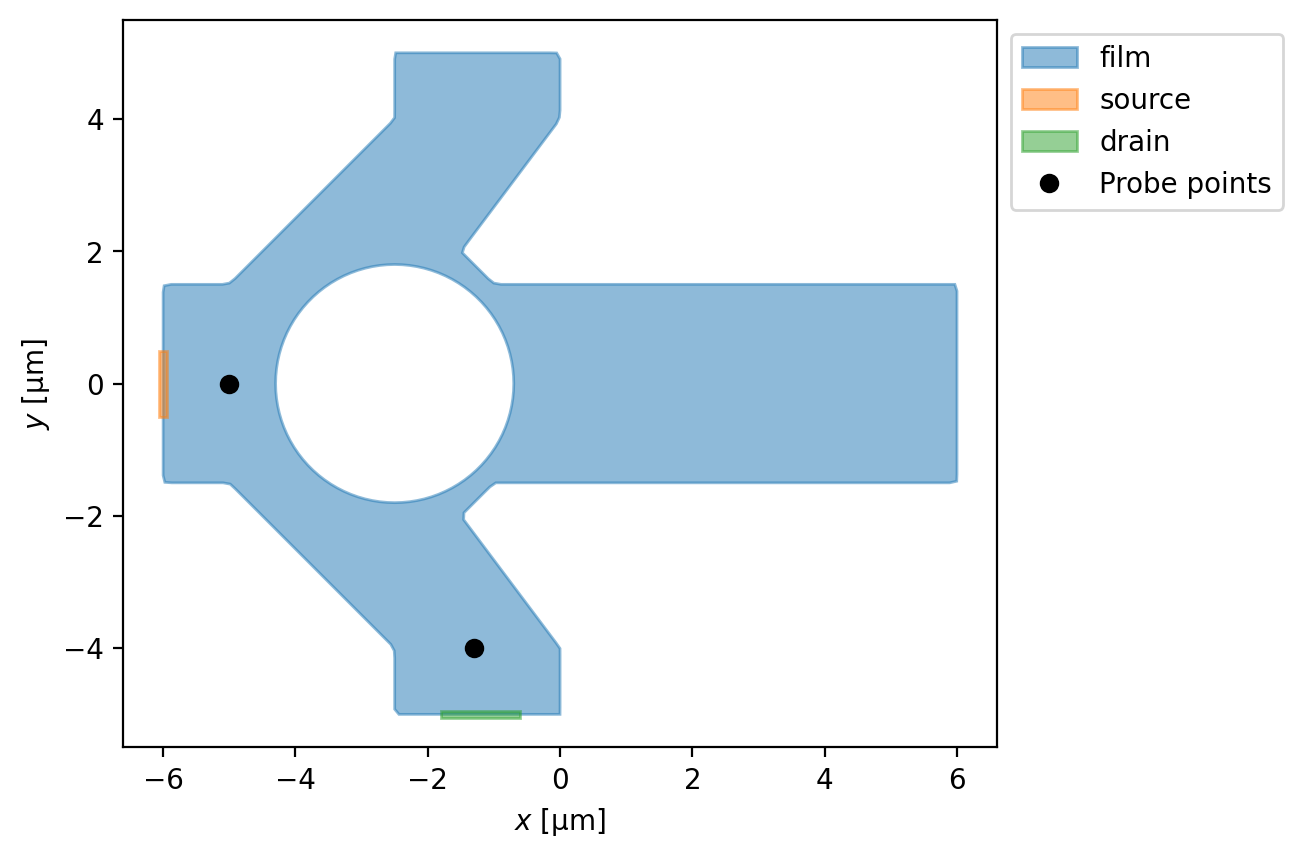

In [43]:
ltb_device = tdgl.Device(
    "ltb",
    layer=layer,
    film=film,
    holes=[hole],
    length_units=length_units,
    terminals=[left_source, bot_drain],
    probe_points=[left_probe, bot_probe],
)

devices.append(ltb_device)

fix, ax = ltb_device.draw()

In [ ]:
plt.figure(figsize=(16, 12))

for i, d in enumerate(devices):
    d.make_mesh(max_edge_length=coherence_length/2, smooth=100)
    
    ax = plt.subplot(2, 2, i + 1)
    fig, _ = d.plot(mesh=True, legend=False, ax=ax)

    ax.set_title(f"{d.name}", fontsize=14)

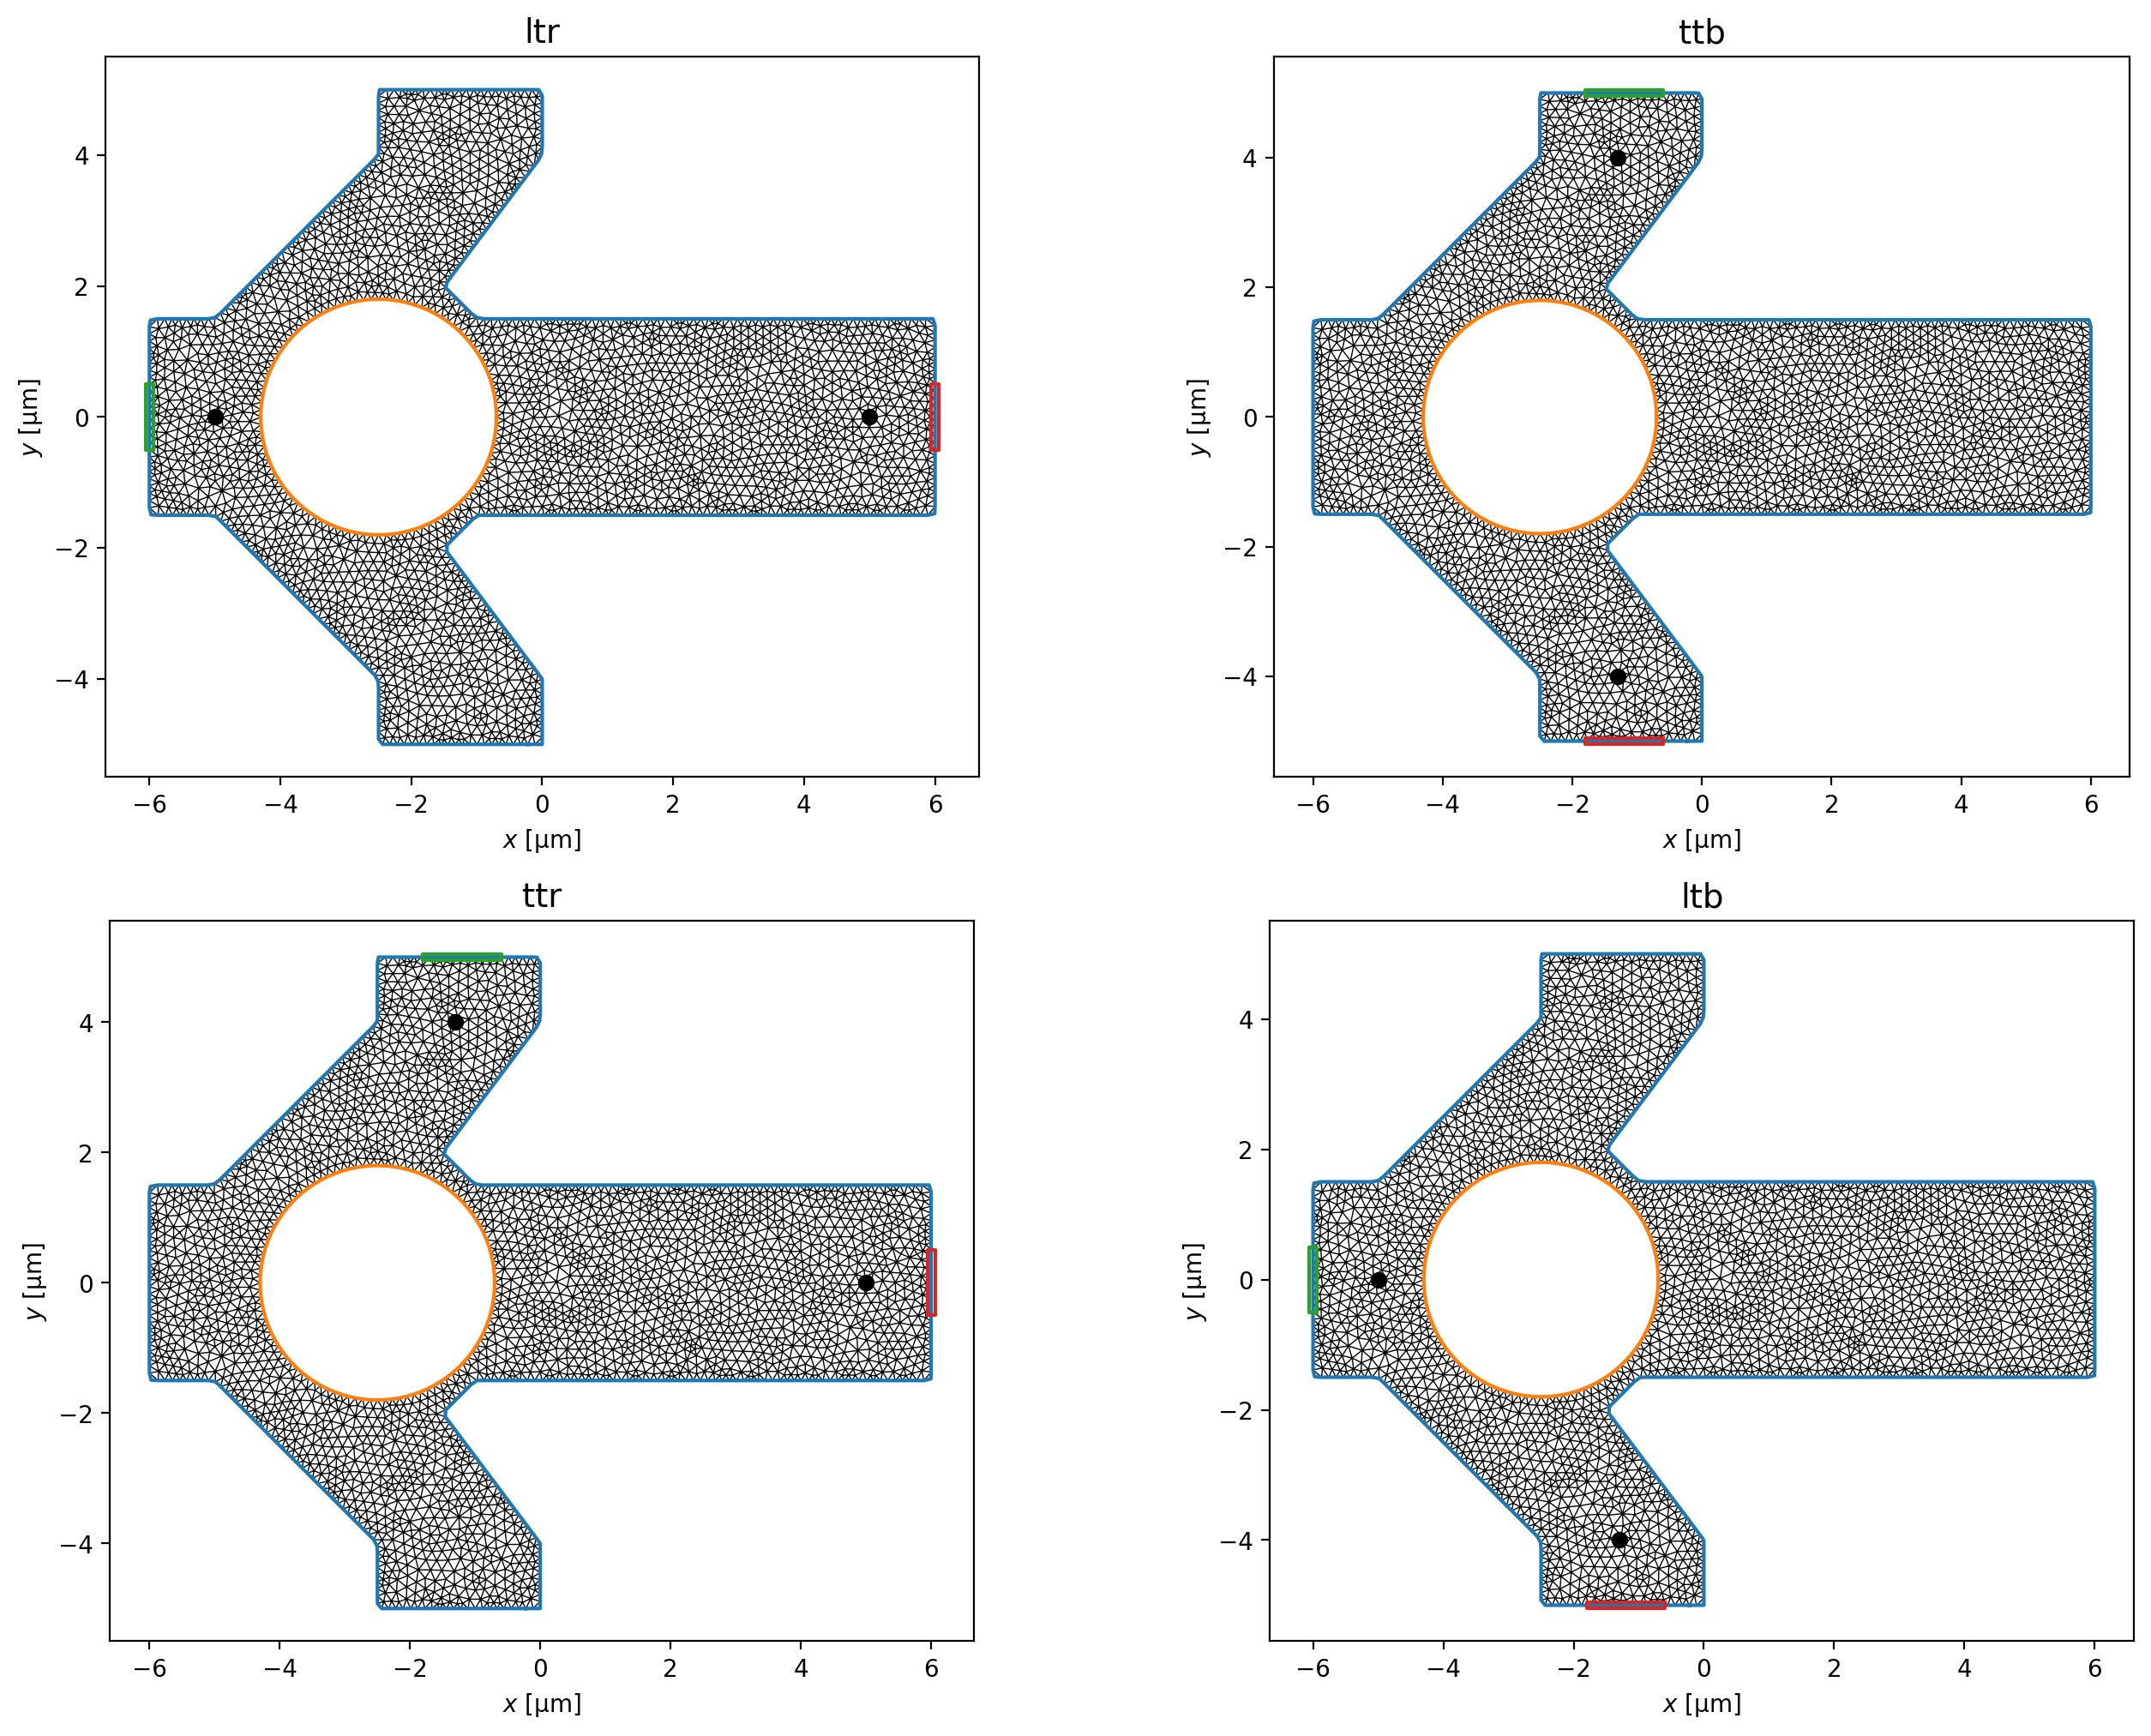

In [61]:
plt.show()

In [ ]:
default_terminal_currents = {
    'source': 12,
    'drain': -12
}


fig, axes = plt.subplots(len(devices), 2, figsize=(12, 4*len(devices)), constrained_layout=True)

for i, d in enumerate(devices):
    with tempfile.TemporaryDirectory(dir=os.getcwd()) as tmpdir:
        options = tdgl.SolverOptions(
            solve_time = 200,
            output_file = os.path.join(tmpdir, "current_field.h5"),
            field_units= "mT",
            current_units= "uA",
        )
        solve = tdgl.solve(device=d, options=options, terminal_currents=default_terminal_currents)

        solve.plot_currents(ax=axes[i, 0], streamplot=False)
        axes[i, 0].set_title(f"{d.name} (density)", fontsize=12)

        solve.plot_currents(ax=axes[i, 1], streamplot=True)
        axes[i, 1].set_title(f"{d.name} (streamlines)", fontsize=12)

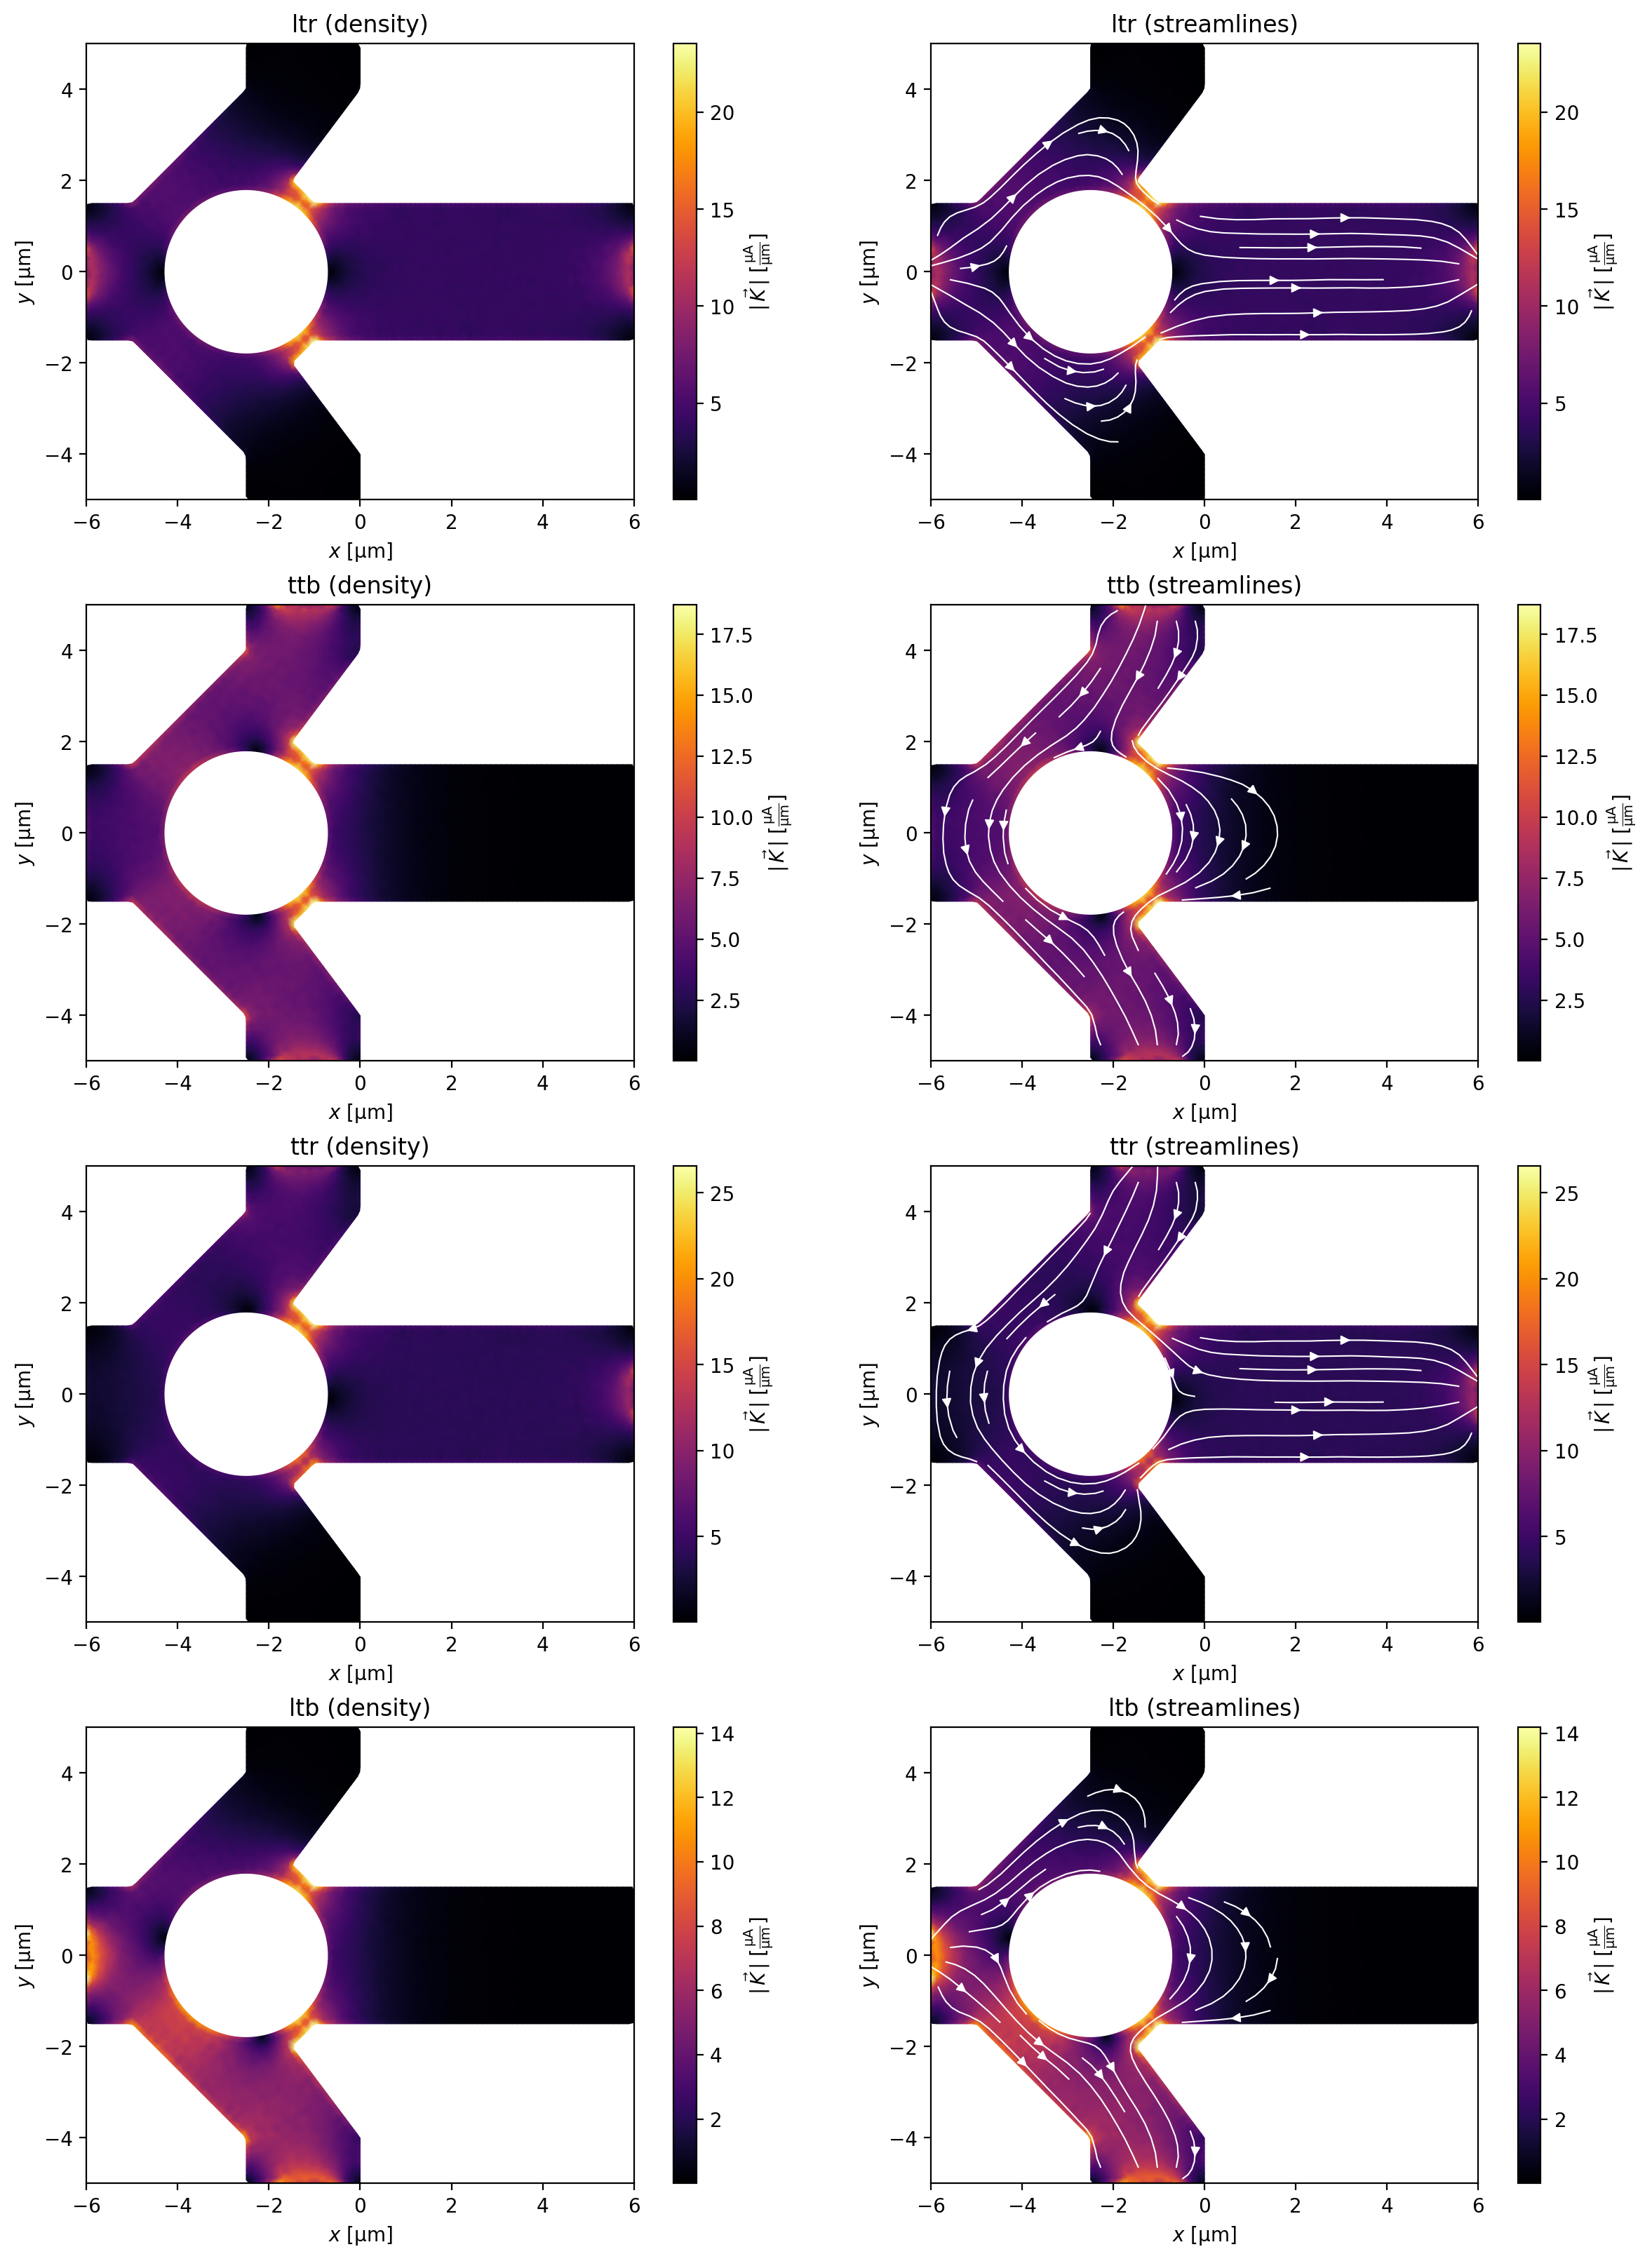

In [58]:
plt.show()